In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
df= pd.read_csv("cleaned_data.csv")

In [3]:
df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,LocationID,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,No-show
0,13721,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,40,0,1,0,0,0,0,0
1,31661,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,40,0,0,0,0,0,0,0
2,22024,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,47,0,0,0,0,0,0,0
3,52847,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,55,0,0,0,0,0,0,0
4,54030,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,40,0,1,1,0,0,0,0


In [4]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"],  
 errors = "coerce")
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], 
 errors = "coerce")

### For feature engineering. I will focus on exploiting the two datetime variables: scheduledDay and AppointmentDay. We will extract year, month, week, day of week, hour of day all as their own variables. In addition, we will calculate the lag between scheduled day and appointment day as a new variable

In [5]:
df["ScheduledDay_year"] = df["ScheduledDay"].dt.year
df["ScheduledDay_month"] = df["ScheduledDay"].dt.month
df["ScheduledDay_week"] = df["ScheduledDay"].dt.week
df["ScheduledDay_day"] = df["ScheduledDay"].dt.day
df["ScheduledDay_hour"] = df["ScheduledDay"].dt.hour
df["ScheduledDay_dayofweek"] = df["ScheduledDay"].dt.dayofweek
df["AppointmentDay_year"] = df["AppointmentDay"].dt.year
df["AppointmentDay_month"] = df["AppointmentDay"].dt.month
df["AppointmentDay_week"] = df["AppointmentDay"].dt.week
df["AppointmentDay_day"] = df["AppointmentDay"].dt.day
df["AppointmentDay_hour"] = df["AppointmentDay"].dt.hour
df["AppointmentDay_dayofweek"] = df["AppointmentDay"].dt.dayofweek

df["days_diff"] = (df["AppointmentDay"]-df["ScheduledDay"]).dt.total_seconds()/(60*60*24)

C:\Users\kylek\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kylek\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


### We will also generate a variable that checks if a patient has previous records of No-show. And a another variable counts the total number of No-show a patient has up to the point they scheduled a new appointment. (These two varaibles only look to the past and do not cheat by looking into the future)

In [175]:
#And sort the dataframe by AppointmentDay in asecending order
df = df.sort_values(by='AppointmentDay',ascending=True)

In [176]:
#loop to generate the prior no show varaible. 

previous_no_show = []
for idx,row in df.iterrows():
    temp = df.iloc[0:idx,]
    if temp.loc[temp['PatientID']==row['PatientID'],'No-show'].sum() > 0:
        previous_no_show.append(1)
    elif temp.loc[temp['PatientID']==row['PatientID'],'No-show'].sum() == 0:
        previous_no_show.append(0)

previous_total_no_show = []
for idx,row in df.iterrows():
    temp = df.iloc[0:idx,]
    previous_total_no_show.append(temp.loc[temp['PatientID']==row['PatientID'],'No-show'].sum())


In [177]:
previous__no_show = pd.Series(previous_no_show)
df['prior_no_show'] = previous_no_show 
previous_total_no_show = pd.Series(previous_total_no_show)
df['previous_total_no_show'] = previous_total_no_show 

### Let's see if any of these newly generated features are predictive of no-show

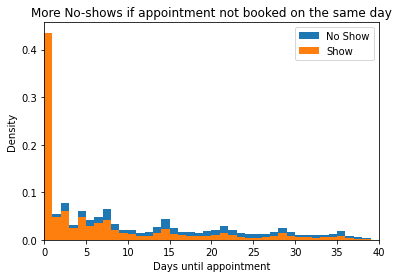

In [178]:
plt.hist(df.loc[df["No-show"] == 1,"days_diff"], 
label = "No Show",bins = range(0,40,1),density=True, stacked=True)
plt.hist(df.loc[df["No-show"] == 0,"days_diff"], 
label = "Show",bins = range(0,40,1),density=True, stacked=True)
plt.legend()
plt.xlabel("Days until appointment")
plt.ylabel("Density")
plt.title("More No-shows if appointment not booked on the same day")
plt.xlim(0,40)
plt.show()

In [6]:
bins = [0,1,2,3,4,5,6,7,8,10,15,25,40]
days_diff_no_show = df.groupby(pd.cut(df.days_diff, bins))['No-show'].sum() / df.groupby(pd.cut(df.days_diff, bins))['No-show'].count()

In [7]:
days_diff_no_show 

days_diff
(0, 1]      0.046460
(1, 2]      0.213297
(2, 3]      0.237932
(3, 4]      0.235897
(4, 5]      0.232809
(5, 6]      0.265769
(6, 7]      0.247766
(7, 8]      0.266925
(8, 10]     0.282227
(10, 15]    0.316037
(15, 25]    0.328335
(25, 40]    0.330373
Name: No-show, dtype: float64

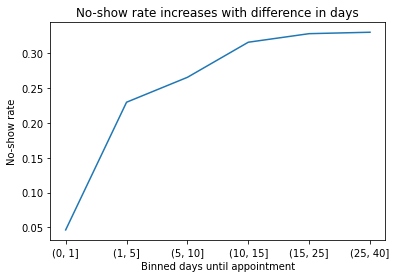

In [15]:
bins = [0,1,5,10,15,25,40]
days_diff_no_show = df.groupby(pd.cut(df.days_diff, bins))['No-show'].sum() / df.groupby(pd.cut(df.days_diff, bins))['No-show'].count()

days_diff_no_show.plot.line()
plt.xlabel("Binned days until appointment")
plt.ylabel("No-show rate")
plt.title("No-show rate increases with difference in days")
plt.show()

Text(0.5, 1.0, 'No-show percent by prior no-show status')

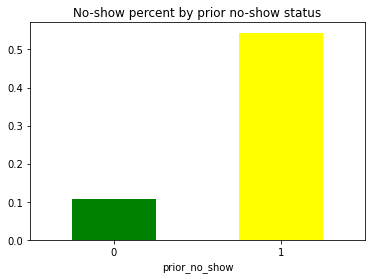

In [11]:
prior_no_show = df.groupby('prior_no_show')['No-show'].sum()/df.groupby('prior_no_show')['No-show'].count()
prior_no_show.to_csv('no_show_rate_based_on_prior_no_show.csv')
prior_no_show.plot.bar(x='Prior_no_show', y='Percent', color=["green","yellow"],rot=0)
plt.title("No-show percent by prior no-show status")

In [88]:
df.groupby('AppointmentDay_dayofweek')['No-show'].sum()/df.groupby('AppointmentDay_dayofweek')['No-show'].count()

AppointmentDay_dayofweek
0    0.206412
1    0.200750
2    0.196871
3    0.193704
4    0.212431
5    0.230769
Name: No-show, dtype: float64

In [13]:
df.groupby('AppointmentDay_month')["No-show"].sum()/df.groupby("AppointmentDay_month")["No-show"].count()

AppointmentDay_month
4    0.196157
5    0.207785
6    0.184731
Name: No-show, dtype: float64

In [14]:
df.groupby('ScheduledDay_hour')["No-show"].sum()/df.groupby("ScheduledDay_hour")["No-show"].count()

ScheduledDay_hour
6     0.192259
7     0.151417
8     0.182827
9     0.196920
10    0.220722
11    0.227752
12    0.203252
13    0.209470
14    0.226844
15    0.231810
16    0.237897
17    0.247937
18    0.212845
19    0.233607
20    0.300000
21    0.333333
Name: No-show, dtype: float64

In [15]:
df.groupby('AppointmentDay_day')["No-show"].sum()/df.groupby("AppointmentDay_day")["No-show"].count()

AppointmentDay_day
1     0.182226
2     0.191421
3     0.195968
4     0.233598
5     0.189024
6     0.194928
7     0.184874
8     0.172853
9     0.225105
10    0.230179
11    0.197760
12    0.190617
13    0.227056
14    0.230769
16    0.227312
17    0.213712
18    0.203207
19    0.209155
20    0.234632
24    0.201899
25    0.193854
29    0.196157
30    0.196805
31    0.178881
Name: No-show, dtype: float64

In [16]:
df.groupby('Disability')["No-show"].sum()/df.groupby("Disability")["No-show"].count()

Disability
0    0.202355
1    0.179236
Name: No-show, dtype: float64

### Dig into SMS Recieved

SMS_received
0    0.166947
1    0.275857
Name: No-show, dtype: float64

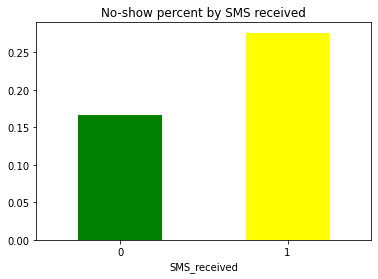

In [34]:
sms_received = df.groupby('SMS_received')["No-show"].sum()/df.groupby("SMS_received")["No-show"].count()
sms_received.plot.bar(x='Recieved', y='Percent', color=["green","yellow"],rot=0)
plt.title("No-show percent by SMS received")

sms_received

In [36]:
df.groupby(['SMS_received')

SMS_received
0    47275
1    27080
Name: PatientID, dtype: int64

In [40]:
df.groupby(['SMS_received'])['No-show'].sum()

SMS_received
0    12503
1     9775
Name: No-show, dtype: int64

In [41]:
df.groupby(['SMS_received'])['No-show'].count()

SMS_received
0    74892
1    35435
Name: No-show, dtype: int64

In [59]:
df.groupby('SMS_received')['days_diff'].mean()

SMS_received
0     6.540839
1    19.545052
Name: days_diff, dtype: float64

In [158]:
bins = [0,1,2,3,3.2,4,5,10,15,25,40]

days_diff_sms_recieved = df.groupby([pd.cut(df.days_diff, bins),'SMS_received'],as_index=False)['No-show'].agg(['sum','mean','count'])
#df.groupby([pd.cut(df.days_diff, bins),'SMS_received'],)['No-show'].agg({'Total No-show':'sum','No-show Rate':'mean','Total Appointments':'count'})


In [163]:
days_diff_sms_recieved.columns=['Total No-show','No-show Rate','Total Appointments']

### ISSUE here is that text messages not recieved until three days after appointment is booked.

In [164]:
days_diff_SMS_No_show = pd.DataFrame(days_diff_sms_recieved)
days_diff_SMS_No_show

Total No-show  No-show Rate  Total Appointments
days_diff    SMS_received                                                 
(0.0, 1.0]   0                      1788      0.046460               38485
             1                         0           NaN                   0
(1.0, 2.0]   0                      1110      0.213297                5204
             1                         0           NaN                   0
(2.0, 3.0]   0                      1597      0.237932                6712
             1                         0           NaN                   0
(3.0, 3.2]   0                         7      0.250000                  28
             1                         0           NaN                   0
(3.2, 4.0]   0                       444      0.246667                1800
             1                       193      0.213969                 902
(4.0, 5.0]   0                       543      0.243389                2231
             1                       686      0.225066                3048
(5.0, 10.0]  0                      1751      0.286111                6120
             1                      2534      0.253122               10011
(10.0, 15.0] 0                      1255      0.357143                3514
             1                      1297      0.284367                4561
(15.0, 25.0] 0                      1768      0.371273                4762
             1                      1998      0.297853                6708
(25.0, 40.0] 0                      1523      0.372281                4091
             1                      2048      0.304853                6718

In [167]:
(1788+1100+1597)/df['No-show'].sum()

0.20131968758416374

In [147]:
df.loc[df['days_diff']>3.2,].groupby('SMS_received')["No-show"].sum()/df.loc[df['days_diff']>3.2,].groupby("SMS_received")["No-show"].count()

SMS_received
0    0.326928
1    0.275857
Name: No-show, dtype: float64

Text(0.5, 1.0, 'No-show percent by MedicadeIND')

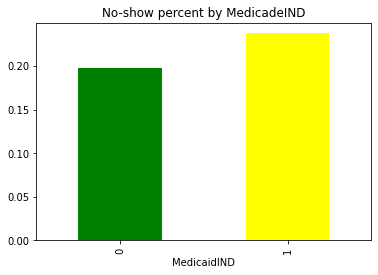

In [180]:
medicaidIND = df.groupby('MedicaidIND')["No-show"].sum()/df.groupby('MedicaidIND')["No-show"].count()
medicaidIND.plot.bar(x='Recieved', y='Percent', color=["green","yellow"])
plt.title("No-show percent by MedicadeIND")

In [181]:
locationID_noshow = df.groupby('LocationID')["No-show"].sum()/df.groupby("LocationID")["No-show"].count()
locationID_noshow[locationID_noshow>0.25]

LocationID
35    1.000000
37    0.262618
66    0.274554
67    0.265347
75    0.289639
Name: No-show, dtype: float64

In [182]:
df.groupby('Diabetes')["No-show"].sum()/df.groupby('Diabetes')["No-show"].count()

Diabetes
0    0.203618
1    0.180000
Name: No-show, dtype: float64

### -  Target variable is unbalanced. We will use the random over sampler.

In [183]:
#remove appointment ID, ScheduledDay, and AppointmentDay 
df = pd.get_dummies(df, columns=['Gender'],drop_first=True)
df = df.drop(['ScheduledDay','AppointmentDay','AppointmentID'],axis=1)

#first train-test split to seperate the test set that I am going to report the model performance on
train, test = train_test_split(df, test_size=0.25, random_state=42, stratify=df['No-show'])


#upsampling 
# Note: I made sure there is no data leakage during this process
print("Upsampling training...")  
ros = RandomOverSampler(sampling_strategy='auto')
X_train, y_train = ros.fit_resample(train.drop(['No-show'],axis=1), train['No-show'])
X_test = test.copy(deep=True).drop(['No-show'], axis=1)
y_test = test['No-show']
assert X_test.shape[0] == y_test.shape[0], "wrong shapes for test set"
assert X_train.shape[0] == y_train.shape[0], "wrong shapes for training set"

Upsampling training...


In [184]:
print("y_train shape")
print(y_train.value_counts())
print("y_test shape")
print(y_test.value_counts())

y_train shape
0    66037
1    66037
Name: No-show, dtype: int64
y_test shape
0    22012
1     5570
Name: No-show, dtype: int64


In [185]:
X_train.to_csv("X_train.csv",index=False)
y_train.to_csv("y_train_.csv",index=False)
X_test.to_csv("X_test.csv",index=False)
y_test.to_csv("y_test.csv",index=False)